## Movie Recommendation System 

In [ ]:
## Importing necessary Libraries 
import pandas as pd 
import numpy as np 
import seaborn as sns
!pip install scikit-learn

In [ ]:
credits = pd.read_csv('C:/Users/Vibhav/Desktop/Python Project/Data/credits.csv')
movies = pd.read_csv('C:/Users/Vibhav/Desktop/Python Project/Data/movies_meta_data.csv')

In [ ]:
credits.head()

In [ ]:
movies.head()

In [ ]:
print("Describe Credits DataFrame : ")
print(credits.describe())
print("---------------------------------------------------------------")
print("Dim of Credits DataFarme : ")
print(credits.shape)
print("---------------------------------------------------------------")
print("Data types of Credits DataFarme : ")
print(credits.dtypes)

In [ ]:
print("Describe movies DataFrame : ")
print(movies.describe())
print("---------------------------------------------------------------")
print("Dim of movies DataFarme : ")
print(movies.shape)
print("---------------------------------------------------------------")
print("Data types of Movies DataFarme : ")
print(movies.dtypes)

In [ ]:
## Merging to create a Master Table
credits.columns = ['id','tittle','cast','crew']
movies= movies.merge(credits,on='id')

In [ ]:
movies.head(5)

In [ ]:
movies.info()

In [ ]:
print("Describe movies DataFrame : ")
print(movies.describe())
print("---------------------------------------------------------------")
print("Dim of movies DataFarme : ")
print(movies.shape)

In [ ]:
movie = pd.DataFrame()

In [ ]:
movie['genres'] = movies['genres'].astype(str).str.strip('[]').str.replace(' ','').str.replace("'",'')
movie['genres'] = movies['genres'].astype(str).str.split(',')

In [ ]:
movie['director'] = movies['director'].astype(str).apply(xstr)
ax = movie[movie['director']!=''].director.value_counts()[:10].sort_values(ascending=True).plot.barh(width=0.9,color=sns.color_palette('muted',40))
for i, v in enumerate(movie[movie['director']!=''].director.value_counts()[:10].sort_values(ascending=True).values): 
    ax.text(.5, i, v,fontsize=12,color='white',weight='bold')
plt.title('Directors with highest movies')
plt.show()

### using IMDB's weighted rating (wr): 

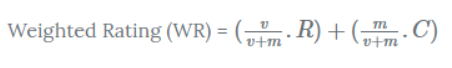 

where,

v is the number of votes for the movie;      
m is the minimum votes required to be listed as popular movies;    
R is the average rating of the movie; And     
C is the mean vote across the whole report     

In [ ]:
## C can be calculated from Votes field in DataFrame

C= movies['vote_average'].mean()
print("Printing Vote_average C : ")
print(C)

### The mean rating of all the movies is 6.092, hence 6.092 out of 10.
We need to find the minimum votes cuttoff to be considered as popular movie , We are assuming 90th percentile as cuttoff (for a movie to be featured in as popular movie , it must have more votes than atleast 90 % of the total movies in list. 

In [ ]:
m= movies['vote_count'].quantile(0.9)
m

Using the cuttoff calculated above m = 1838, we are filtering the movies to be considered as popular movies

In [ ]:
popular_movies = movies.copy().loc[movies['vote_count'] >= m]
popular_movies.shape

We see that there are 481 movies which qualify to be in this list of popular movies. 
To calculate metric for each qualified movie by defining a function, weighted_rating() and define a new feature score

In [ ]:
def weighted_rating(x, m=m, C=C):
    v = x['vote_count']
    R = x['vote_average']
    # Calculation based on the IMDB formula
    return (v/(v+m) * R) + (m/(m+v) * C)

In [ ]:
# Define a new feature 'score' and calculate its value with `weighted_rating()`
popular_movies['score'] = popular_movies.apply(weighted_rating, axis=1)

### Finally, sorting the DataFrame based on the score feature and output the title, vote count, vote average and weighted rating or score of the top 10 movies.

In [ ]:
#Sort movies based on score calculated above
popular_movies = popular_movies.sort_values('score', ascending=False)

#Print the 15 movies from the popular movies
popular_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

In [ ]:
pop= popular_movies.sort_values('score', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(20),pop['score'].head(20), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

The above recommended movies are general recommended movies to all the users. They are not sensitive to the interests and tastes of a particular user. 

Moving on to a more refined system personalized - Content Basesd Filtering.

### Content Based Filtering 

#### Plot description based Recommender
- We will compute pairwise similarity scores for all movies based on their plot descriptions and recommend movies based on that   similarity score. The plot description is given in the overview feature of our dataset. Hence the chosen Content here is the     overview of the movie 
- Based on the content (Movie - overview) using TF-IDF (Term frequency - Inverse Document Frequency) and cosine similarity we 
  can identify similar movies and recommend accordingly

In [ ]:
movies['overview'].head(5)

In [ ]:
# Import TFIDF from scikit - learn
from sklearn.feature_extraction.text import TfidfVectorizer


In [ ]:
#Defining a TF-IDF Vectorizer Object. Remove all english stop words such as 'the', 'a'
tfidf= TfidfVectorizer(stop_words='english')

#Replace NaN with an empty string
movies['overview'] = movies['overview'].fillna('')

#Construct the required TF-IDF matrix by fitting and transforming the data
tfidf_matrix = tfidf.fit_transform(movies['overview'])

#shape of tfidf_matrix
tfidf_matrix.shape

### We see that over 20,978 different words were used to describe the 4803 movies in our dataset.
- Using the above mentioned matrix we can compute similarity score 
- Using Cosine Similarty Score https://en.wikipedia.org/wiki/Cosine_similarity to find similarity to calculate a numeric           quantity that denotes the similarity between two movies.
- We use the cosine similarity score since it is independent of magnitude and is relatively easy and fast to calculate.           Mathematically, it is defined as follows:
  
  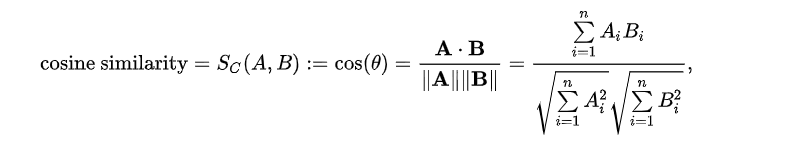
  
  

   

In [ ]:
# We can use linear_kernel() or cosine_similarities(), picking linear_kernel() 
# Getting error for cosine_similarities() , we have to come up with reason to use linear_kernel()
# Import linear_kernel
from sklearn.metrics.pairwise import linear_kernel

# Compute the cosine similarity matrix
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

In [ ]:
#Construct a reverse map of indices and movie titles
indexes = pd.Series(movies.index, index=movies['title']).drop_duplicates()

In [ ]:
indexes

## Function that takes in movie title as input and outputs most similar movies


In [ ]:
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indexes[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indexes = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies['title'].iloc[movie_indexes]

### Testing Similar Movies based on TF - IDF

In [ ]:
get_recommendations('The Dark Knight Rises')

In [ ]:
get_recommendations('The Avengers')

In [ ]:
movies[movies['title']=="Plastic"]

### Content Based Recommendation Part II Approach 
In the Part I Content based recommendation approach , The recommendation is based on the similarity of movie plot
We can improve content based recommendation by considering various other meta data attributes like actors , Director and Genre and movie plot

In [ ]:
# Parse the stringified features into their corresponding python objects
from ast import literal_eval

features = ['cast', 'crew', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(literal_eval)

In [ ]:
movies[feature]

In [ ]:
# Get the director's name from the crew feature. If director is not listed, return NaN
def get_director(x):
    for i in x:
        if i['job'] == 'Director':
            return i['name']
    return np.nan

In [ ]:
# Returns the list top 3 elements or entire list; whichever is more.
def get_list(x):
    if isinstance(x, list):
        names = [i['name'] for i in x]
        #Check if more than 3 elements exist. If yes, return only first three. If no, return entire list.
        if len(names) > 3:
            names = names[:3]
        return names

    #Return empty list in case of missing/malformed data
    return []

In [ ]:
# Define new director, cast, genres and keywords features that are in a suitable form.
movies['director'] = movies['crew'].apply(get_director)

features = ['cast', 'keywords', 'genres']
for feature in features:
    movies[feature] = movies[feature].apply(get_list)

In [ ]:
# Print the new features of the first 10 films
movies[['title', 'cast', 'director', 'keywords', 'genres']].head(10)

In [ ]:
# Function to convert all strings to lower case and strip names of spaces
def clean_data(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        #Check if director exists. If not, return empty string
        if isinstance(x, str):
            return str.lower(x.replace(" ", ""))
        else:
            return ''

In [ ]:
# Apply clean_data function to your features.
features = ['cast', 'keywords', 'director', 'genres']

for feature in features:
    movies[feature] = movies[feature].apply(clean_data)

In [ ]:
def create_soup(x):
    return ' '.join(x['keywords']) + ' ' + ' '.join(x['cast']) + ' ' + x['director'] + ' ' + ' '.join(x['genres'])
movies['soup'] = movies.apply(create_soup, axis=1)

In [ ]:
# Import CountVectorizer and create the count matrix
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(movies['soup'])

In [ ]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim2 = cosine_similarity(count_matrix, count_matrix)

In [ ]:
# Reset index of our main DataFrame and construct reverse mapping as before
movies = movies.reset_index()
indices = pd.Series(movies.index, index=movies['title'])

In [ ]:
get_recommendations('The Dark Knight Rises', cosine_sim2)

In [ ]:
name = input('Enter the name of the movie watched : ')
get_recommendations(name, cosine_sim2)

### Collaborative filtering Approach

## References :

https://surpriselib.com/

In [ ]:
from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate
reader = Reader()

In [ ]:
ratings = pd.read_csv('C:/Users/manju/Desktop/Python Project/Data/ratings.csv')
ratings.head()

In [ ]:
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)
data.split(n_folds=5)